In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (average_precision_score, accuracy_score, precision_score, recall_score, 
                             f1_score, fbeta_score, roc_auc_score, confusion_matrix, cohen_kappa_score, 
                             precision_recall_curve, PrecisionRecallDisplay, precision_recall_fscore_support)
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import mysql.connector
import math
from math import sqrt
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.base import clone
from sklearn.svm import SVC

In [2]:
# MySQL database connection
conn = mysql.connector.connect(
    user='root',
    password='***',
    host='localhost',
    database='tez'
)

# Fetch data from the database
query = "SELECT * FROM mim"
cursor = conn.cursor()
cursor.execute(query)
data = cursor.fetchall()
columns = cursor.column_names

# Create a DataFrame and clean the data
df = pd.DataFrame(data, columns=columns)
df = df.dropna()  # Remove rows with missing values
df['outcome'] = df['outcome'].astype(int)  # Convert 'outcome' column to integer type
conn.close()  # Close the database connection

# Split features and target variable
X = df.drop(['outcome'], axis=1)  # Features
y = df['outcome']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Combine training and testing data into DataFrames for further use
trainData = pd.DataFrame(data=np.column_stack((y_train, X_train)), columns=columns)
testData = pd.DataFrame(data=np.column_stack((y_test, X_test)), columns=columns)

In [63]:

C = np.array([[0, 7],[1,  0]]) 

sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
np.random.seed(2345)
GRB= GradientBoostingClassifier(n_estimators=18, learning_rate=0.08, random_state=42).fit(X_train, y_train,sample_weight =sample_weight)
GRModel= GradientBoostingClassifier(n_estimators=18, learning_rate=0.08, random_state=42)
GR=GRModel.fit(X_train, y_train)
MetaCostGR = MetaCost(trainData, GRModel, C).fit('outcome', 2)


RFB = RandomForestClassifier(class_weight='balanced',n_estimators=15, random_state=42).fit(X_train, y_train)
RFModel = RandomForestClassifier(n_estimators=15, random_state=42)
RF=RFModel.fit(X_train, y_train)
MetaCostRF =  MetaCost(trainData, RFModel, C).fit('outcome', 2)

DTB = DecisionTreeClassifier(class_weight='balanced',random_state=0, max_depth=15).fit(X_train, y_train)
DTModel = DecisionTreeClassifier(random_state=0, max_depth=15)
DT=DTModel.fit(X_train, y_train)
MetaCostDT =  MetaCost(trainData, DTModel, C).fit('outcome', 2)

LRB = LogisticRegression(class_weight='balanced',max_iter=1000, random_state=42,solver='liblinear').fit(X_train, y_train)
LRModel = LogisticRegression(random_state=0, max_iter=200,solver='liblinear')
LR=LRModel.fit(X_train, y_train)
MetaCostLR = MetaCost(trainData, LRModel, C).fit('outcome', 2)


XGB_B = XGBClassifier(eval_metric="logloss").fit(X_train, y_train,sample_weight =sample_weight)
XGBModel = XGBClassifier(eval_metric="logloss")
XGB=XGBModel.fit(X_train, y_train)
MetaCostXGB =  MetaCost(trainData, XGBModel, C).fit('outcome', 2)

In [12]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

class MetaCost:
    """
    MetaCost algorithm for cost-sensitive learning.
    
    Parameters:
    -----------
    S : pd.DataFrame
        Training data as a DataFrame.
    L : object
        Base classifier model (must have `fit` and `predict_proba` methods).
    C : np.ndarray
        Cost matrix where C[i, j] is the cost of misclassifying class i as class j.
    m : int, default=50
        Number of bootstrap samples to create.
    n : float, default=1
        Size of each bootstrap sample as a fraction of the training data size.
    p : bool, default=True
        If True, use predict_proba for probability estimates.
        If False, use hard predictions.
    q : bool, default=True
        If True, use all models for prediction.
        If False, exclude models where the instance was in the bootstrap sample.
    """
    
    def __init__(self, S, L, C, m=50, n=1, p=True, q=True):
        # Validate inputs
        if not isinstance(S, pd.DataFrame):
            raise ValueError('S must be a pandas DataFrame.')
        if not hasattr(L, 'fit') or not (hasattr(L, 'predict_proba') or hasattr(L, 'predict')):
            raise ValueError('L must be a classifier with fit and predict/predict_proba methods.')
        if not isinstance(C, np.ndarray) or C.ndim != 2:
            raise ValueError('C must be a 2D numpy array representing the cost matrix.')
        
        # Reset index for consistency
        S = S.reset_index(drop=True)
        
        # Assign attributes
        self.S = S
        self.L = L
        self.C = C
        self.m = m
        self.n = int(len(S) * n)
        self.p = p
        self.q = q

    def fit(self, target, num_classes):
        """
        Fit the MetaCost model.
        
        Parameters:
        -----------
        target : str
            Name of the target column in the DataFrame.
        num_classes : int
            Number of unique classes in the target variable.
        
        Returns:
        --------
        model_new : object
            Trained model with relabeled data.
        """
        # Features (all columns except target)
        features = [col for col in self.S.columns if col != target]
        
        # Dictionary to store bootstrap samples
        bootstrap_samples = {}
        
        # List to store trained models
        models = []
        
        # Step 1: Create m bootstrap samples and train models
        for i in range(self.m):
            # Create a bootstrap sample
            bootstrap_samples[i] = self.S.sample(n=self.n, replace=True)
            
            # Prepare features and target
            X = bootstrap_samples[i][features].values
            y = bootstrap_samples[i][target].values
            
            # Train the model on the bootstrap sample
            model = clone(self.L)
            models.append(model.fit(X, y))
        
        # Step 2: Relabel the training data
        relabeled_targets = []
        S_features = self.S[features].values
        
        for i in range(len(self.S)):
            # Exclude models where the instance was in the bootstrap sample (if q is False)
            if not self.q:
                excluded_models = [k for k, sample in bootstrap_samples.items() if i not in sample.index]
                selected_models = [models[k] for k in excluded_models]
            else:
                selected_models = models
            
            # Calculate class probabilities or hard predictions
            if self.p:
                # Use predict_proba for probability estimates
                class_probabilities = [model.predict_proba(S_features[[i]]) for model in selected_models]
            else:
                # Use hard predictions
                class_probabilities = []
                for model in selected_models:
                    prediction = int(model.predict(S_features[[i]])[0])
                    prob_vector = np.zeros(num_classes)
                    prob_vector[prediction] = 1
                    class_probabilities.append(prob_vector)
            
            # Average class probabilities
            avg_probabilities = np.mean(class_probabilities, axis=0).flatten()  # (num_classes,) boyutuna düzleştir
            
            # Calculate expected cost and assign the label with minimum cost
            expected_cost = self.C.dot(avg_probabilities)  # (num_classes, num_classes) x (num_classes,) = (num_classes,)
            relabeled_targets.append(np.argmin(expected_cost))
        
        # Step 3: Train a new model on the relabeled data
        X_train = self.S[features].values
        y_train = np.array(relabeled_targets)
        
        model_new = clone(self.L)
        model_new.fit(X_train, y_train)
        
        return model_new

In [88]:
df

,outcome,gendera,hypertensive,atrialfibrillation,CHDwithnoMI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renalfailure,...,Bloodsodium,Bloodcalcium,Chloride,Aniongap,Magnesiumion,PH,Bicarbonate,Lacticacid,PCO2,EF
0,0,0,0,0,0,1,1,0,1,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230000,21.166667,0.500,40.000000,55.0
1,0,1,0,0,0,0,1,0,0,1,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268000,30.571429,0.500,71.500000,35.0
2,0,1,0,0,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370000,38.571429,0.600,75.000000,55.0
3,0,0,1,1,0,0,1,0,1,1,...,136.250000,8.466667,96.750000,13.125000,1.771429,7.310000,30.500000,0.600,65.500000,35.0
4,0,0,1,0,0,0,0,0,1,1,...,144.133333,8.775000,106.666667,15.200000,1.875000,7.169231,26.800000,0.625,69.769231,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,0,0,1,1,0,0,0,0,0,0,...,137.800000,7.925000,102.400000,16.600000,2.250000,7.273333,23.000000,3.550,48.333333,55.0
424,0,0,0,0,0,0,0,0,0,0,...,135.666667,8.400000,100.333333,13.333333,2.050000,7.370000,26.333333,3.775,29.000000,20.0
425,0,0,1,0,0,1,0,0,1,1,...,135.444444,8.571429,99.444444,15.888889,1.900000,7.368125,24.333333,4.150,43.000000,20.0
426,0,1,1,0,0,1,0,1,0,1,...,141.823529,8.500000,101.470588,12.066667,2.005882,7.385806,32.933333,4.160,42.870968,55.0


In [83]:
#C = np.array([[0,7.965429868602331], [1.8343478986616382, 0]])
C = np.array([[0, 7],[1,  0]]) 

sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
np.random.seed(2345)
GRB= GradientBoostingClassifier(n_estimators=18, learning_rate=0.08, random_state=42).fit(X_train, y_train,sample_weight =sample_weight)
GRModel= GradientBoostingClassifier(n_estimators=18, learning_rate=0.08, random_state=42)
GR=GRModel.fit(X_train, y_train)
MetaCostGR = MetaCost(trainData, GRModel, C).fit('outcome', 2)


RFB = RandomForestClassifier(class_weight='balanced',n_estimators=15, random_state=42).fit(X_train, y_train)
RFModel = RandomForestClassifier(n_estimators=15, random_state=42)
RF=RFModel.fit(X_train, y_train)
MetaCostRF =  MetaCost(trainData, RFModel, C).fit('outcome', 2)

DTB = DecisionTreeClassifier(class_weight='balanced',random_state=0, max_depth=15).fit(X_train, y_train)
DTModel = DecisionTreeClassifier(random_state=0, max_depth=15)
DT=DTModel.fit(X_train, y_train)
MetaCostDT =  MetaCost(trainData, DTModel, C).fit('outcome', 2)

LRB = LogisticRegression(class_weight='balanced',max_iter=1000, random_state=42,solver='liblinear').fit(X_train, y_train)
LRModel = LogisticRegression(random_state=0, max_iter=200,solver='liblinear')
LR=LRModel.fit(X_train, y_train)
MetaCostLR = MetaCost(trainData, LRModel, C).fit('outcome', 2)


XGB_B = XGBClassifier(eval_metric="logloss").fit(X_train, y_train,sample_weight =sample_weight)
XGBModel = XGBClassifier(eval_metric="logloss")
XGB=XGBModel.fit(X_train, y_train)
MetaCostXGB =  MetaCost(trainData, XGBModel, C).fit('outcome', 2)

In [15]:
def get_summary_statistics(df, target_column):
    stats_list = []
    
    for col in df.columns:
        if col != target_column:
            stats = df.groupby(target_column)[col].agg(['mean', 'std', 'min', 'max'])
            stats['mean_std'] = stats['mean'].round(2).astype(str) + ' ± ' + stats['std'].round(2).astype(str)
            stats['min'] = stats['min'].round(2)
            stats['max'] = stats['max'].round(2)
            stats['variable'] = col
            stats = stats.reset_index()
            stats_list.append(stats[['variable', target_column, 'mean_std', 'min', 'max']])
    
    summary_df = pd.concat(stats_list, axis=0)
    stats = stats.reset_index()
    summary_df = summary_df.pivot(index='variable', columns=target_column)
    
    # Flatten the MultiIndex columns
    summary_df.columns = ['_'.join(map(str, col)).strip() for col in summary_df.columns.values]
    
    return summary_df

summary_statistics = get_summary_statistics(df, 'outcome')


summary_statistics.head(150)

,mean_std_0,mean_std_1,min_0,min_1,max_0,max_1
variable,,,,,,
Aniongap,13.77 ± 2.34,16.06 ± 3.33,7.78,10.33,25.27,24.88
BMI,31.28 ± 9.96,28.51 ± 7.12,13.67,15.82,83.26,65.12
Basophils,0.41 ± 0.33,0.33 ± 0.32,0.10,0.10,3.00,2.00
Bicarbonate,27.44 ± 5.41,23.37 ± 5.58,15.07,12.86,47.67,40.57
Bloodcalcium,8.51 ± 0.53,8.12 ± 0.63,6.97,6.70,10.95,9.72
Bloodpotassium,4.15 ± 0.37,4.31 ± 0.45,3.24,3.40,5.82,5.52
Bloodsodium,139.38 ± 3.76,139.04 ± 4.8,121.05,124.46,149.13,149.00
CHDwithnoMI,0.07 ± 0.25,0.08 ± 0.27,0.00,0.00,1.00,1.00
COPD,0.09 ± 0.29,0.05 ± 0.21,0.00,0.00,1.00,1.00


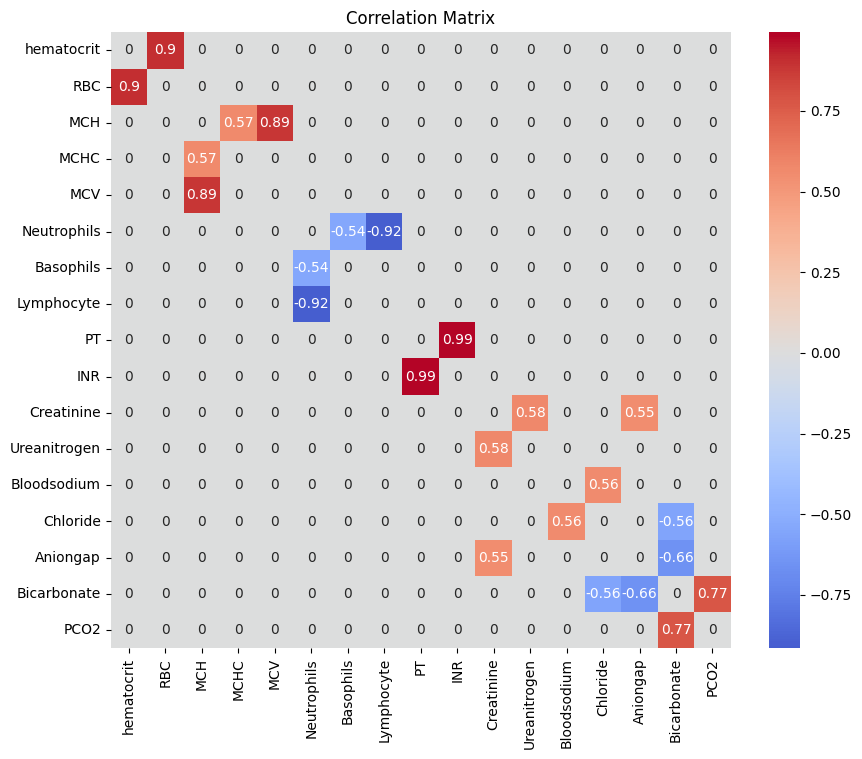

In [18]:
# Korelasyon matrisini hesaplama
correlation_matrix = df.corr()
filtered_matrix = correlation_matrix[(abs(correlation_matrix) >= 0.5) & (correlation_matrix != 1.0)]
filtered_matrix = filtered_matrix.fillna(0)
filtered_matrix = filtered_matrix.loc[~(filtered_matrix == 0).all(axis=1)]
filtered_matrix = filtered_matrix.loc[:, ~(filtered_matrix == 0).all(axis=0)]

# Korelasyon matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

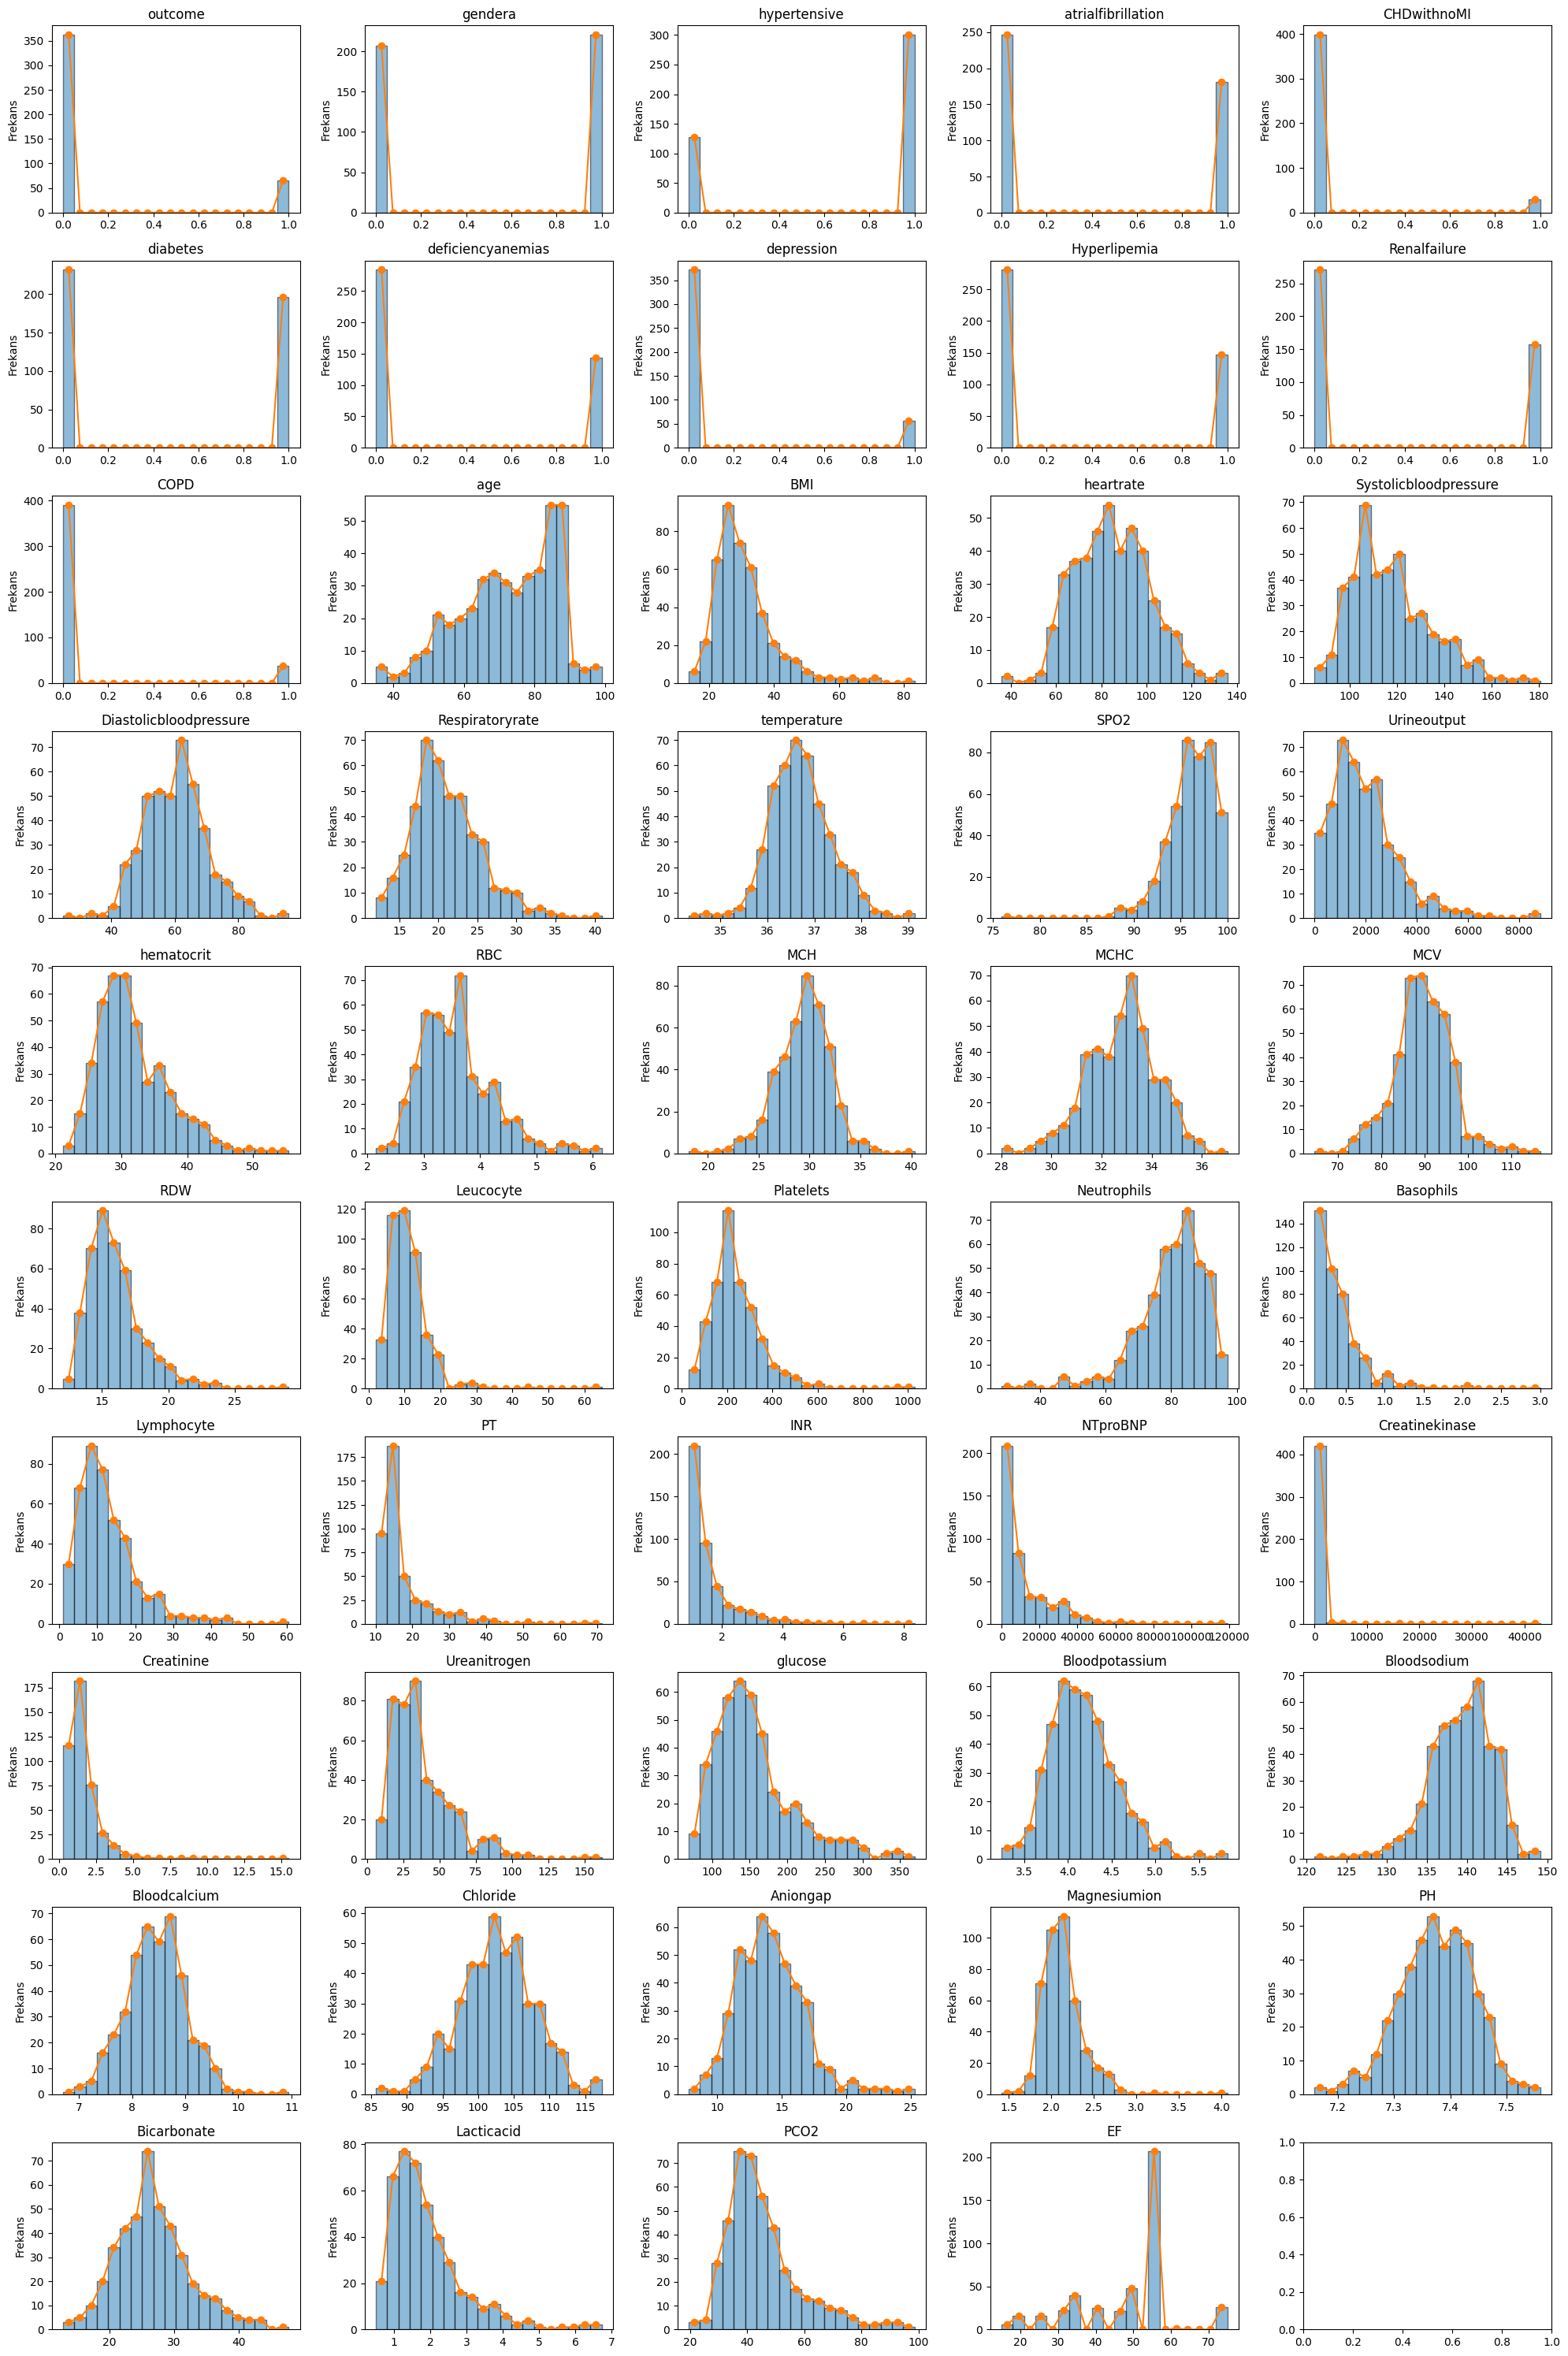

In [19]:
# Tüm sütunların histogramını tek bir grafikte gösterme
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20, 30))

for i, column in enumerate(df.columns):
    ax = axes[i//5, i%5]  # Her bir sütunun konumunu belirleme
    counts, bins, _ = ax.hist(df[column], bins=20, alpha=0.5, label='Histogram', edgecolor='black') 
    #ax.hist(df[column], bins=20)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Her bir kutunun merkezi
    ax.plot(bin_centers, counts, marker='o', linestyle='-', label='Poligon')  # Poligon çizimi
    ax.set_title(f'{column}')
    #ax.set_xlabel('Değer')
    ax.set_ylabel('Frekans')

# Grafiklerin arasındaki boşlukları ayarla
plt.tight_layout()
plt.show()

Explanation for Instance 18


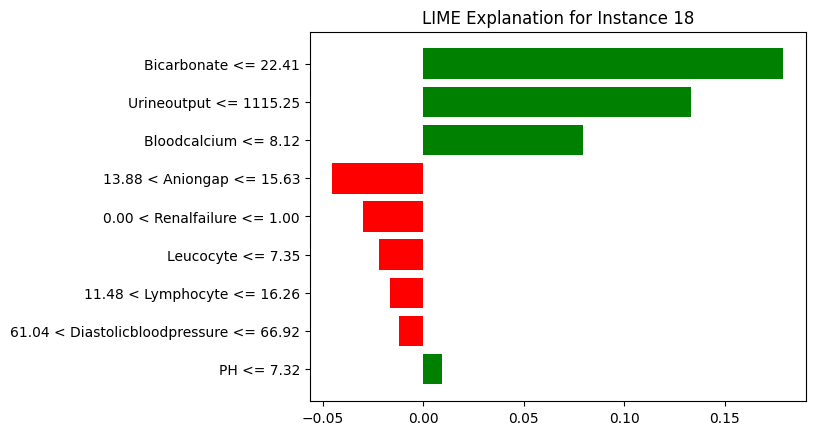

In [31]:
from lime.lime_tabular import LimeTabularExplainer
testData1 = testData.drop([ 'outcome'], axis=1)
explainer = LimeTabularExplainer(
    testData1.values,
    feature_names=testData1.columns,
    class_names=['Alive', 'Not Alive'],
    mode='classification',
    
)
i =18 # Açıklama üretmek istediğimiz gözlemin indeksini belirtin
exp = explainer.explain_instance(testData1.values[i], MetaCostGR.predict_proba,num_features=9 )
print(f"\033[1mExplanation for Instance {i}\033[0m")
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {i}")
plt.show()

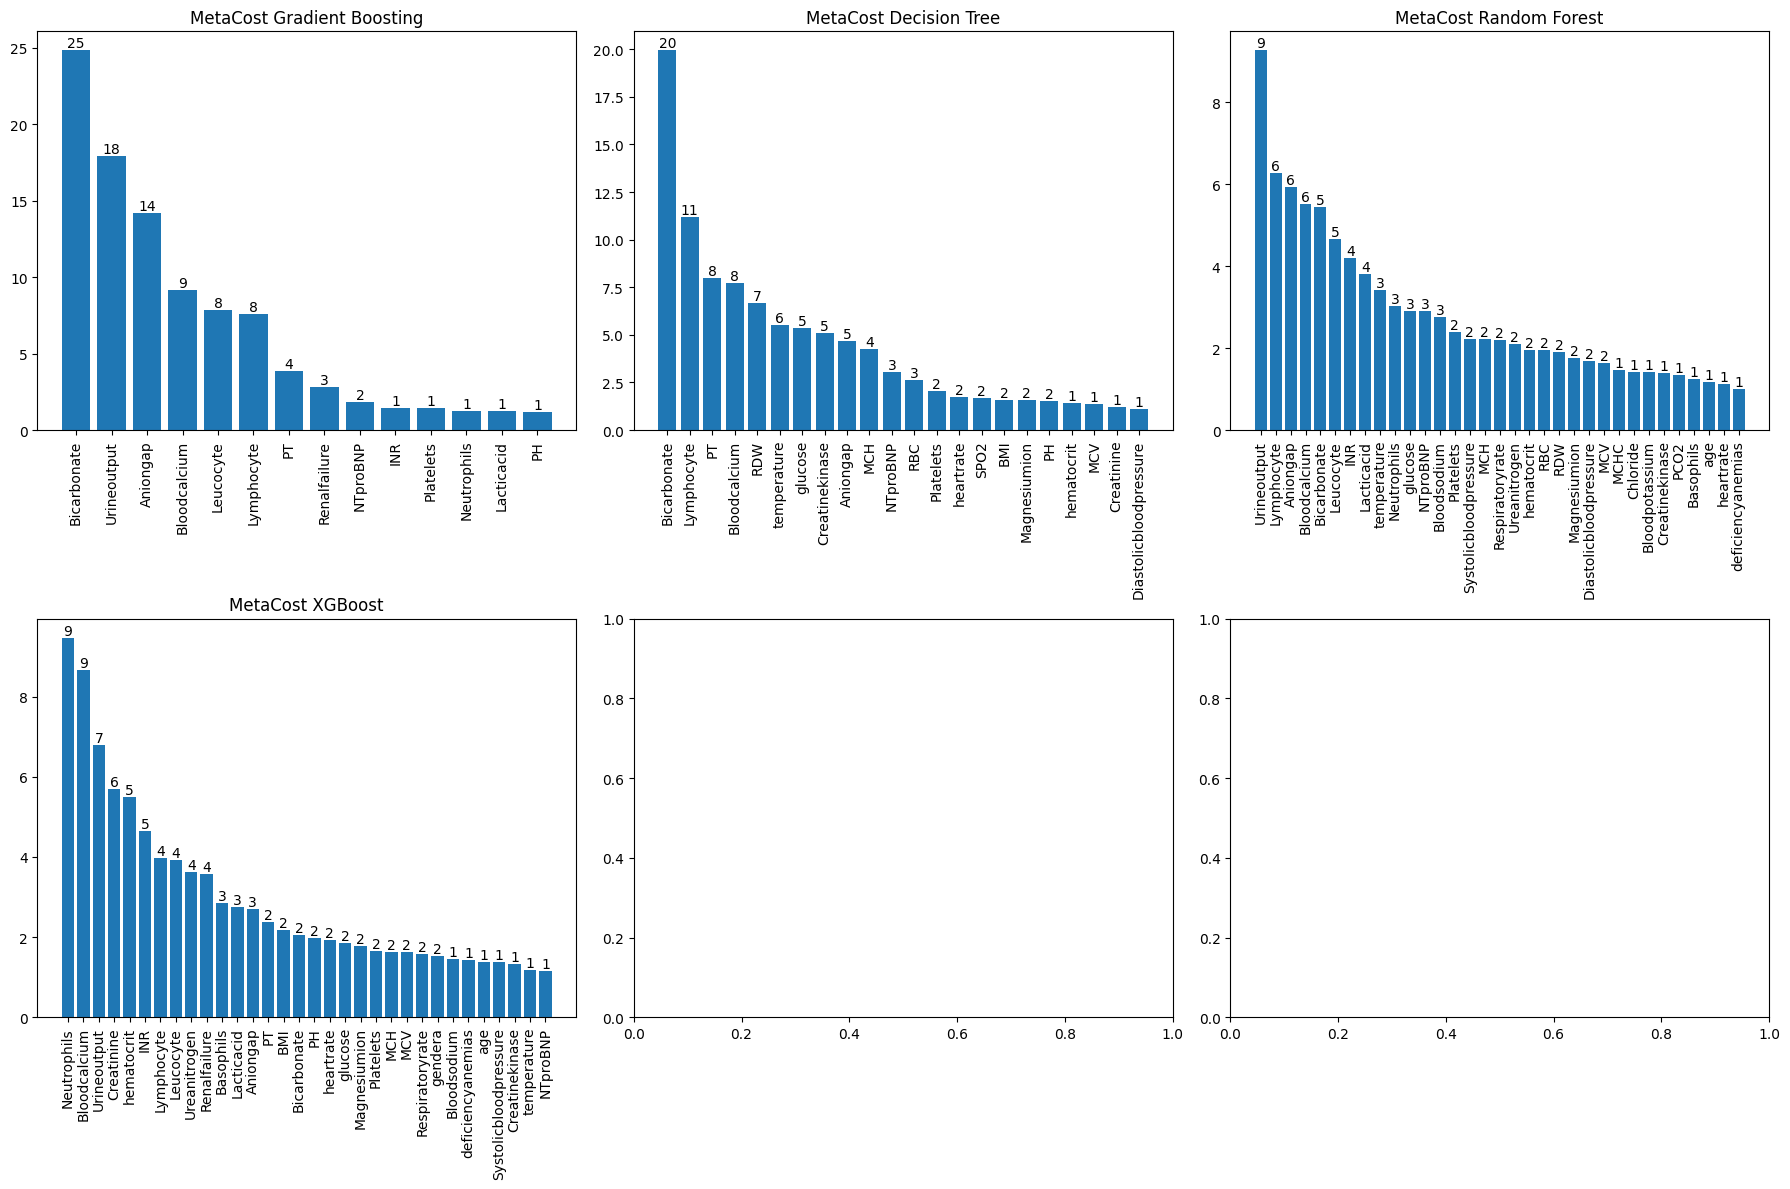

In [56]:
# Example list of models with their names and trained instances
models = [
    ("MetaCost Gradient Boosting", MetaCostGR), 
    ("MetaCost Decision Tree", MetaCostDT),
    ("MetaCost Random Forest", MetaCostRF), 
    ("MetaCost XGBoost", MetaCostXGB),
]

# Assuming the feature names are available
#feature_names = [...]  # Your feature names
XX = df.drop([ 'outcome'], axis=1)
feature_names=XX.columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models):
    # Assuming models have `feature_importances_` or `coef_` attributes
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_*100
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        importances = None

    if importances is not None:
        # Filter out features with importance less than 10
        indices = np.where(importances >= 1)[0]
        sorted_indices = np.argsort(importances[indices])[::-1]
        sorted_importances = importances[indices][sorted_indices]
        sorted_features = [feature_names[i] for i in indices[sorted_indices]]

        # Plot the feature importances
        ax.bar(range(len(sorted_features)), sorted_importances, align='center')
        ax.set_xticks(range(len(sorted_features)))
        ax.set_xticklabels(sorted_features, rotation=90)
        ax.set_title(name)
        
        # Annotate the bars with importance scores
        for i, v in enumerate(sorted_importances):
            ax.text(i, v, f'{v:.0f}', ha='center', va='bottom')

fig.tight_layout()
plt.show()

In [64]:
coefficients = MetaCostLR.coef_[0] # Katsayılar (tek boyutlu) 
trainData_dropped = trainData.iloc[1:] # İlk satırı sildik 
feature_names = trainData_dropped.columns.tolist() # Başlıkları liste şeklinde aldık 
feature_names.pop(0)
coeff_df = pd.DataFrame({ 'Feature': feature_names, 'Coefficient': coefficients })
coeff_df['Absolute_Coefficient'] = coeff_df['Coefficient'] 
coeff_df = coeff_df.sort_values(by='Absolute_Coefficient', ascending=False).reset_index(drop=True)
lr_coeff_df = coeff_df[['Feature', 'Coefficient']] 


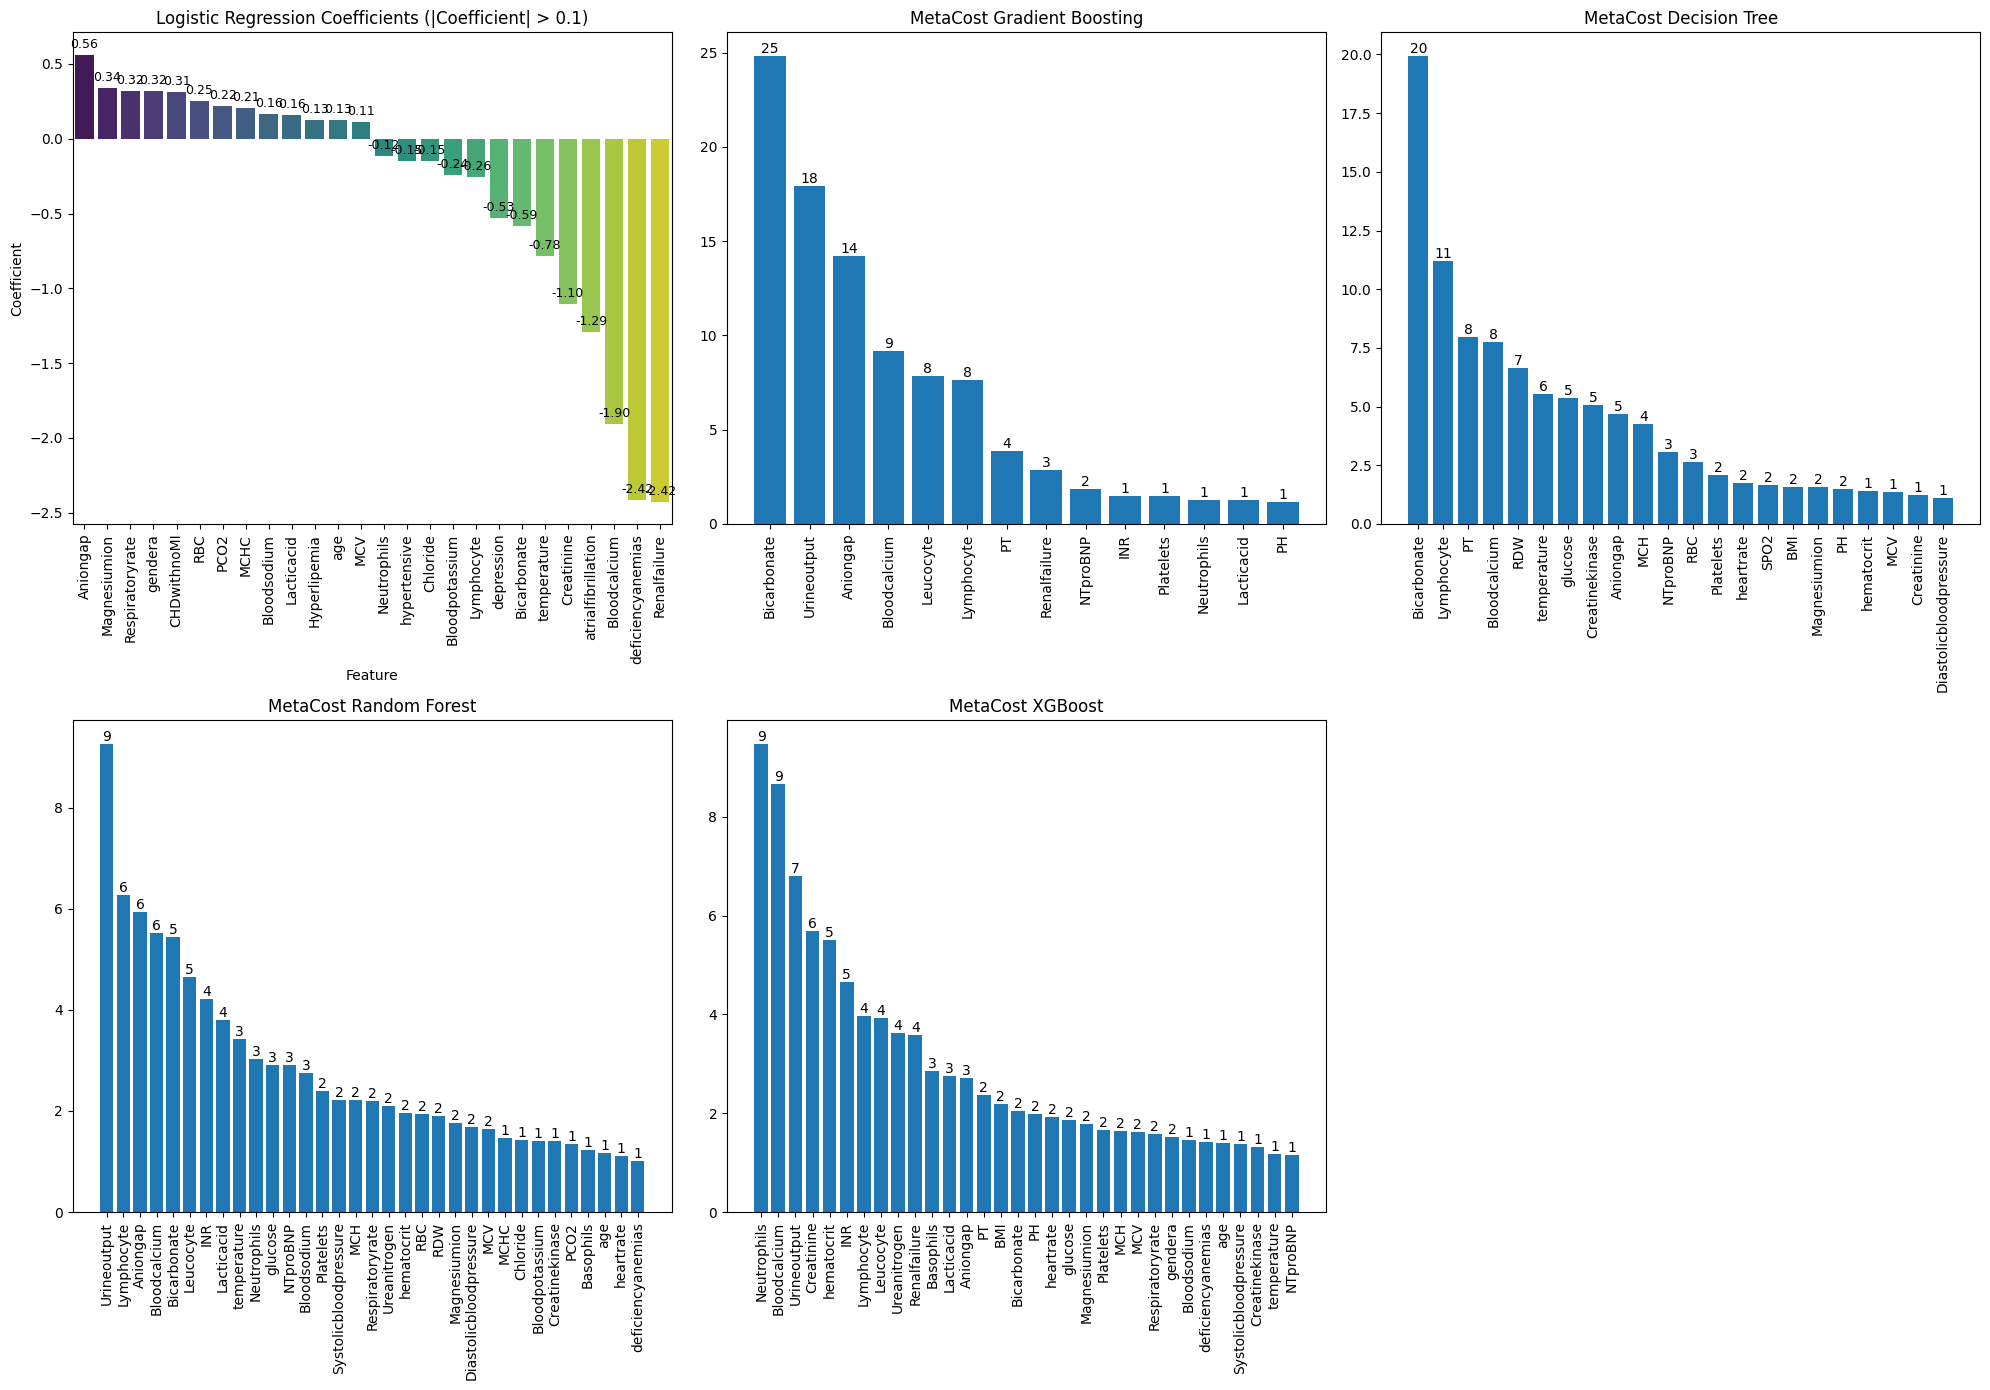

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))  # 2 satır, 3 sütun
axes = axes.flatten()  # Tüm eksenleri düz listeye çevir
filtered_coeff_df_LR = lr_coeff_df[lr_coeff_df['Coefficient'].abs() > 0.1]
# Logistic Regression katsayı grafiği (ilk grafik)
sns.barplot(x='Feature', y='Coefficient', data=filtered_coeff_df_LR, palette='viridis', ax=axes[0])
axes[0].set_title('Logistic Regression Coefficients (|Coefficient| > 0.1)', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')

# İlk satırda Decision Tree ve SVC modelleri
for i, (name, model) in enumerate(models[:2], start=1):  # İlk iki model (Decision Tree, SVC)
    ax = axes[i]
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_ * 100
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        importances = None

    if importances is not None:
        indices = np.where(importances >= 1)[0]
        sorted_indices = np.argsort(importances[indices])[::-1]
        sorted_importances = importances[indices][sorted_indices]
        sorted_features = [feature_names[j] for j in indices[sorted_indices]]

        ax.bar(range(len(sorted_features)), sorted_importances, align='center')
        ax.set_xticks(range(len(sorted_features)))
        ax.set_xticklabels(sorted_features, rotation=90)
        ax.set_title(name, fontsize=12)
        
        for k, v in enumerate(sorted_importances):
            ax.text(k, v, f'{v:.0f}', ha='center', va='bottom')

# İkinci satırda Random Forest ve XGBoost modelleri
for i, (name, model) in enumerate(models[2:], start=3):  # Son iki model (Random Forest, XGBoost)
    ax = axes[i]
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_ * 100
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        importances = None

    if importances is not None:
        indices = np.where(importances >= 1)[0]
        sorted_indices = np.argsort(importances[indices])[::-1]
        sorted_importances = importances[indices][sorted_indices]
        sorted_features = [feature_names[j] for j in indices[sorted_indices]]

        ax.bar(range(len(sorted_features)), sorted_importances, align='center')
        ax.set_xticks(range(len(sorted_features)))
        ax.set_xticklabels(sorted_features, rotation=90)
        ax.set_title(name, fontsize=12)
        
        for k, v in enumerate(sorted_importances):
            ax.text(k, v, f'{v:.0f}', ha='center', va='bottom')

# Son eksen boş bırakılır
axes[5].axis('off')

# Genel ayarlar
fig.tight_layout()
plt.show()


In [70]:
# List of categorical variables to analyze
categorical_vars = [
    'gendera',
    'CHDwithnoMI',
    'COPD',
    'Hyperlipemia',
    'Renalfailure',
    'atrialfibrillation',
    'deficiencyanemias',
    'depression',
    'diabetes',
    'hypertensive'
]

# Initialize an empty list to store the results
results = []

# Loop through each categorical variable
for var in categorical_vars:
    # Group by outcome and the variable, then count the occurrences
    counts = df.groupby(['outcome', var]).size().reset_index(name='Count')
    
    # Calculate percentages
    total_counts = df.groupby('outcome').size().reset_index(name='Total')
    merged = counts.merge(total_counts, on='outcome')
    merged['Percentage'] = (merged['Count'] / merged['Total']) * 100
    
    # Append the results to the list
    for _, row in merged.iterrows():
        results.append({
            'Variable': var,
            'Category': row[var],
            'Outcome': row['outcome'],
            'Count': row['Count'],
            'Percentage': row['Percentage']
        })

# Convert the results list to a DataFrame
result_df = pd.DataFrame(results)

# Pivot the DataFrame to split outcomes into separate columns
pivot_df = result_df.pivot_table(index=['Variable', 'Category'], 
                                 columns='Outcome', 
                                 values=['Count', 'Percentage'],
                                 aggfunc='first').reset_index()

# Flatten the multi-level column index
pivot_df.columns = ['Variable', 'Category', 'Count_0', 'Count_1', 'Percentage_0', 'Percentage_1']

# Format the percentages
pivot_df['Percentage_0'] = pivot_df['Percentage_0'].round(2).astype(str) + '%'
pivot_df['Percentage_1'] = pivot_df['Percentage_1'].round(2).astype(str) + '%'

# Display the final DataFrame
#print(pivot_df)
pivot_df.head(25)

,Variable,Category,Count_0,Count_1,Percentage_0,Percentage_1
0,CHDwithnoMI,0.0,339.0,60.0,93.39%,92.31%
1,CHDwithnoMI,1.0,24.0,5.0,6.61%,7.69%
2,COPD,0.0,329.0,62.0,90.63%,95.38%
3,COPD,1.0,34.0,3.0,9.37%,4.62%
4,Hyperlipemia,0.0,242.0,39.0,66.67%,60.0%
5,Hyperlipemia,1.0,121.0,26.0,33.33%,40.0%
6,Renalfailure,0.0,218.0,53.0,60.06%,81.54%
7,Renalfailure,1.0,145.0,12.0,39.94%,18.46%
8,atrialfibrillation,0.0,215.0,32.0,59.23%,49.23%
9,atrialfibrillation,1.0,148.0,33.0,40.77%,50.77%


In [87]:
# Lojistik regresyon p-değerlerini hesaplayan fonksiyon
def logistic_regression_pvalues(df, target):
    features = df.drop(columns=[target])
    p_values = {}
    
    for feature in df.columns:
        X = df[[feature]]
        X = sm.add_constant(X)  # Sabit terimi ekle
        y = df[target]
        
        model = sm.Logit(y, X)
        result = model.fit(disp=0)
        p_values[feature] = result.pvalues[1]  # Feature'ın p-değerini al
    
    return p_values

# df = pd.read_csv('data.csv')

# outcome değişkenine göre lojistik regresyon p-değerlerini hesaplayın
p_values = logistic_regression_pvalues(df, 'outcome')

# Sonuçları DataFrame'e çevirin ve feature'a göre sıralayın
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p-value'])
p_values_df.sort_index(inplace=True)

p_values_df.head(50)


,p-value
Aniongap,7.085596e-09
BMI,3.372903e-02
Basophils,6.784906e-02
Bicarbonate,1.930350e-07
Bloodcalcium,9.256050e-07
Bloodpotassium,3.801762e-03
Bloodsodium,5.209301e-01
CHDwithnoMI,7.497562e-01
COPD,2.194888e-01
Chloride,2.348858e-02


In [86]:
# Combine dictionaries into a single DataFrame (modified)
combined_df = pd.DataFrame(columns=["Feature", "Test", "p-value"])  # Define empty DataFrame

# Add data to DataFrame
for col in t_test_results.keys():
    combined_df = pd.concat([combined_df, pd.DataFrame({"Feature": [col], "Test": ["t-test"], "p-value": [t_test_results[col]]})], ignore_index=True)

for col in mannwhitney_results.keys():
    if col not in combined_df["Feature"].tolist():  # Check for duplicates before adding
        combined_df = pd.concat([combined_df, pd.DataFrame({"Feature": [col], "Test": ["Mann-Whitney"], "p-value": [mannwhitney_results[col]]})], ignore_index=True)

for col in chi2_results.keys():
    if col not in combined_df["Feature"].tolist():  # Check for duplicates before adding
        combined_df = pd.concat([combined_df, pd.DataFrame({"Feature": [col], "Test": ["Chi-squared"], "p-value": [chi2_results[col]]})], ignore_index=True)

#print(combined_df)

In [80]:

# Initialize empty dictionaries to store results
normality_results = {}
t_test_results = {}
mannwhitney_results = {}
chi2_results = {}
categorical_cols=categorical_vars
# Perform normality test for numerical features only
for col in df.columns:
    if col != 'outcome' and col not in categorical_cols:
        stat, p_value = ks_2samp(df[col], np.random.normal(loc=np.mean(df[col]), scale=np.std(df[col]), size=len(df[col])))
        normality_results[col] = p_value > 0.05

# Perform statistical tests based on feature type
for col in df.columns:
    if col != 'outcome':
        group0 = df[df['outcome'] == 0][col]
        group1 = df[df['outcome'] == 1][col]

        # Categorical features - Chi-squared test
        if col in categorical_cols:
            contingency_table = pd.crosstab(df['outcome'], df[col])
            stat, p_value, dof, expected = chi2_contingency(contingency_table)
            chi2_results[col] = p_value

        # Numerical features - t-test or Mann-Whitney U test
        else:
            if normality_results.get(col, False):  # Check if normality result exists (for numerical features only)
                # Normally distributed - t-test
                stat, p_value = ttest_ind(group0, group1, nan_policy='omit')
                t_test_results[col] = p_value
            else:
                # Non-normally distributed - Mann-Whitney U test
                stat, p_value = mannwhitneyu(group0, group1, alternative='two-sided')
                mannwhitney_results[col] = p_value

# Combine results into a single DataFrame
combined_df = pd.DataFrame({
    "Feature": list(t_test_results.keys()) + list(mannwhitney_results.keys()) + list(chi2_results.keys()),
    "Test": ["t-test" if col in t_test_results else "Mann-Whitney" if col in mannwhitney_results else "Chi-squared" for col in combined_df["Feature"]],
    "p-value": list(t_test_results.values()) + list(mannwhitney_results.values()) + list(chi2_results.values())
})

# Remove duplicates (if any)
combined_df = combined_df.drop_duplicates(subset="Feature", keep="first")
#sorted_df = combined_df.sort_values(by=['Test', 'p-value'], ascending=[True, True])
sorted_df = combined_df.sort_values(by=[ 'Feature'], ascending=[True])
#print(sorted_df)
#print(combined_df)

sorted_df.head(50)

,Feature,Test,p-value
15,Aniongap,t-test,4.172897e-11
20,BMI,Mann-Whitney,5.477448e-02
26,Basophils,Mann-Whitney,1.760595e-03
17,Bicarbonate,Mann-Whitney,4.973886e-08
13,Bloodcalcium,t-test,3.099764e-07
11,Bloodpotassium,t-test,3.148995e-03
12,Bloodsodium,t-test,5.217957e-01
41,CHDwithnoMI,Chi-squared,9.590589e-01
47,COPD,Chi-squared,3.098118e-01
14,Chloride,t-test,2.263911e-02
